<a href="https://colab.research.google.com/github/Mbutle3/MachineLearning/blob/main/Copy_of_lab2_interactive_cs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 AI for Multimodal Cyberharassment Detection



With previous lab learning, you should have some knowledge about how to develop an AI model to detect cyberbullying lauguage. In this lab, we will keep learning how AI can be developed to detect cyberbullying. We will use a publicly available test dataset of cyberbullying images, and deploy an pre-trained AI model to automatically detect cyberbullying images. 
Approach towards analysing the cyber bullying in images in a dataset, there are three steps: 
1. Understand and identify the factors related to cyberbullying in images. 
2. Load the pre-trained model.
3. Fine-tune the model with a small dataset.
3. Evaluate the pre-trained model and your fine-tuned model with the same test dataset.
 - Get the results of accuracy, precision, recall and F1-score
 - plot out the confusion matrix figure

## Download the pre-trained model, test dataset and the dependencies

First, we need to download the pre-trained model and the test dataset used in the lab. Just hit the 'play' button run the code below.

In [1]:
 # download the model and dataset
!wget -O auxes_17.pt https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt # model checkpoints
!wget -O cyberbullying_data.zip https://github.com/cuadvancelab/materials/blob/main/lab2/cyberbullying_data.zip?raw=true # test dataset

--2023-05-04 13:49:03--  https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.144
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from buffalo.box.com attempted to set domain to box.net
Location: /public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2023-05-04 13:49:03--  https://buffalo.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from buffalo.box.com attempted to set domain to box.net
Location: https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2023-05-04 13:49:04--  https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.

In [2]:
# unzip the test data
%%capture
!unzip "/content/cyberbullying_data.zip" -d "/content"

Let's import all our softwares dependencies in our iPython notebook

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [4]:
import pickle
import gzip
import sys
import time
import numpy as np
import math
import os
import random
from skimage import io, transform

## How to identify cyberbullying in images

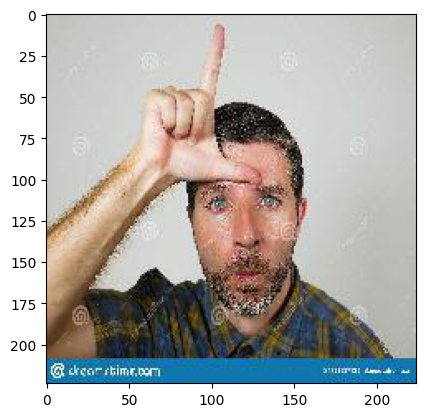

In [5]:
# @title An example image
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
  
# reading the image
testImage = img.imread('/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/7.s-s-unshaven-sad-ashamed-man-doing-loser-sign-hand-fingers-his-front-funny-depressed-face-expression-s-139158713.jpg')
  
# displaying the image
plt.imshow(testImage)

**5 FACTORS to measurement cyberbulling in images**
- Body-pose
- Facial Emotion
- Object
- Gesture
- Social Factors

<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/factors.png?raw=true" alt="drawing" width="600"/>

The follow table shows the analysis of cyberbulling factors in images. Higher value of cosine similarity indicates higher correlation.

| Factor        | Attribute           |  Cyberbulling  |  Non-cyberbulling  |  Description  |
| ------------- |:----------:|:-----:|:-----:| ------------- :|
| Body-pose      | Front pose <br> Non-front pose | 0.86<br>0.50 | 0.53 <br> 0.84 | Pose of subject in image is towards the viewer |
| Emotion      | Joy <br> Sorrow <br> Anger <br> Surprise | 0.34<br>0.02<br>0.09<br>0.07 | 0.25<br>0.02<br>0.04<br>0.05 | Facial emotion of subject in image|
| Gesture      | Hand gesture <br> No hand gesture | 0.71<br>0.70 | 0.32 <br> 0.94 | Hand gesture made by subject in imager |
| Object      | Threatening object <br> No threatening object | 0.33<br>0.94 | 0.06 <br> 0.99 | Threatening object present in image |
| Social      | Anti-LGBT <br> Anti-black racism | 0.45<br>0.03 | 0.06 <br> 0.00 | Anti-LGBT symbols and anti-black racism in image |

More details can be found in 2021 NDSS paper: <em>Towards Understanding and Detecting Cyberbullying in Real-world Images</em> [link](https://www.ndss-symposium.org/wp-content/uploads/ndss2021_7C-4_24260_paper.pdf)

## Load datasets

Now, let's run the subsequent codes to load your data from a predefined
class

In [6]:
class PosesDataset(Dataset):

  def __init__(self, root_dir, poses_dir, auxes_dir):

    self.samples = []
    self.root_dir = root_dir
    self.poses_dir = poses_dir
    self.auxes_dir = auxes_dir

    for _, _, cb_images in os.walk(self.root_dir + 'cyberbullying'): break
    for _, _, non_cb_images in os.walk(self.root_dir + 'non_cyberbullying'): break
    for _, _, cb_poses in os.walk(self.poses_dir + 'cyberbullying'): break
    for _, _, non_cb_poses in os.walk(self.poses_dir + 'non_cyberbullying'): break

    for i in cb_images:
      self.samples.append((self.root_dir + 'cyberbullying/' + i, self.poses_dir + 'cyberbullying/' + i, self.auxes_dir + 'cyberbullying/' + i, 1))  

    for i in non_cb_images:
      self.samples.append((self.root_dir + 'non_cyberbullying/' + i, self.poses_dir + 'non_cyberbullying/' + i, self.auxes_dir + 'non_cyberbullying/' + i, 0))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name, pose_name, aux_name, label = self.samples[idx]
    image = io.imread(img_name)

    aux = pickle.load(open(aux_name + '.p', 'rb'))
    aux = torch.tensor(aux)
    
    # drop the alpha channel for some images
    if image.shape == (224, 224): 
      # handle grayscale images   
      image = np.stack([image, image, image], axis=2)

    if image.shape == (224, 224, 4):
      image = image[:,:,:3]

    image = image.transpose((2, 0, 1)) # C X H X W
    pose = io.imread(pose_name)
    if pose.shape != (224, 224):
      pose = pose[:,:,0]
    pose = np.expand_dims(pose, axis = 0)
    image = np.concatenate((image, pose), axis = 0)
    sample = {'image': torch.from_numpy(image.copy()).float() / 255, 'aux': aux, 'label': label}
    return sample

In [7]:
test_set = PosesDataset('cyberbullying_data/cyberbullying_data_splits_clean/test/', 'cyberbullying_data/cyberbullying_poses/test/', 'cyberbullying_data/cyberbullying_data_auxes/test/')
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = True)

## Load pre-trained AI model

We will use GPU to test our AI if it is available.

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

The AI model prediction process looks like the following figure.
<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/model.png?raw=true" alt="drawing" width="700"/>

In our AI model, we combine the low level image features with the cyberbulling factors identified before. We combine these features using feature fusion techniques.

We use the `VGG16` pre-trained model for image features `CNN` and use a multi-layer perceptron model `MLP` for the factors related features, and combine the feature vectors from both these models using late fusion.

Let's load the pre-trained model to test its capability

In [9]:
# load vgg16 pre-trained model
orig = models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


In [10]:
class CB(nn.Module):
  def __init__(self):
    super(CB, self).__init__()
    self.conv1 = nn.Conv2d(4, 3, 1)
    self.f = nn.Sequential(*list(orig.features.children()))
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.aux_classifier = nn.Sequential(
      nn.Linear(25097, 1024),
      nn.ReLU(),
      nn.Linear(1024, 25088),
      nn.ReLU()  
    )   
    self.classifier = nn.Sequential(*list(orig.classifier.children()))
    self.classifier[-1] = nn.Linear(4096, 2)
    self.sig = nn.Sigmoid()
 
  def forward(self, x, aux):
    x = self.conv1(x) 
    x = self.f(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1) 
    x = torch.cat((x, aux), dim = 1)
    x = self.aux_classifier(x)
    x = self.classifier(x)
    x = self.sig(x) 


    return x


Pass the pre-trained checkpoints to the VGG model so that you can have our pre-trained model

In [11]:
model = torch.load("auxes_17.pt")
model.to(device)

running_loss = []
criterion = nn.CrossEntropyLoss()
correct, incorrect, total = 0., 0., 0.

## Generate the detection resuls for test data

Now, it's time to evaulate the pre-trained model's capability with our test dataset

In [12]:
with torch.no_grad():
  for i_v, data_v in enumerate(test_loader):
    x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
    x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
    y_test_ = model(x_test, aux_test) # forward pass for the pre-trained model
    running_loss.append(criterion(y_test_, y_test))
    _, predicted = torch.max(y_test_.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item() 

print('Test loss is: {:.3f}'.format((sum(running_loss) / len(running_loss)).item()))
print('The accuracy for test dataset is: {}%'.format((correct / total) * 100))


Test loss is: 0.456
The accuracy for test dataset is: 85.0%



- - - -
**<font color='red'>Task 1:</font>
Write code to generate result report contains: Accuracy, Precision, Recall and F1-Score**
- - - -
reference link: https://en.wikipedia.org/wiki/F-score
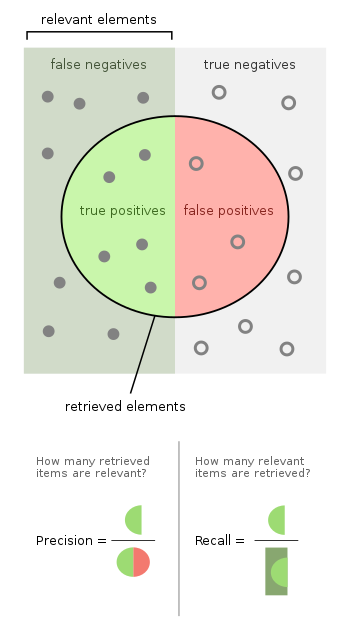

In [13]:
# get the acc, precision, recall, f1 score for the test set

tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
        y_test_ = model(x_test, aux_test) # forward pass for the fine-tuned model
        _, predicted = torch.max(y_test_.data, 1)
        if y_test == 1 and predicted == 1:
            tp += 1
        elif y_test == 1 and predicted == 0:
            fn += 1
        elif y_test == 0 and predicted == 1:
            fp += 1
        elif y_test == 0 and predicted == 0:
            tn += 1

In [14]:
# TODO: Complete the following code to calculate the accuracy, precision, recall and F1 score.
acc = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print('The accuracy for test dataset is: {}%'.format(acc * 100))
print('The precision for test dataset is: {}%'.format(precision * 100))
print('The recall for test dataset is: {}%'.format(recall * 100))
print('The f1 score for test dataset is: {}%'.format(f1 * 100))

The accuracy for test dataset is: 85.0%
The precision for test dataset is: 88.88888888888889%
The recall for test dataset is: 80.0%
The f1 score for test dataset is: 84.21052631578948%



- - - -
**<font color='red'>Task 2:</font>
Write code to plot the confusion matrix** (you are allowed to borrow any python tools, such as scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))
- - - -

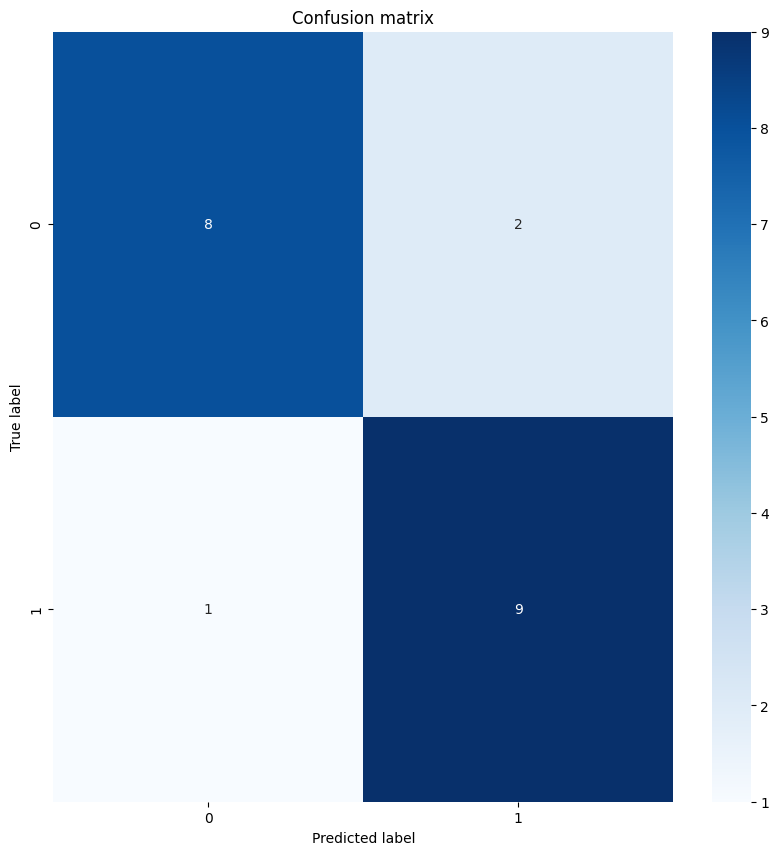

In [15]:
# Complete the following code to get the confusion matrix for the test set
# get the confusion matrix for the test set
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []



# TODO: Write the code to get the y_true and y_pred lists for the test set
# your code here:
model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
        y_test_ = model(x_test, aux_test) # forward pass for the fine-tuned model
        _, predicted = torch.max(y_test_.data, 1)
        if y_test == 1 and predicted == 1:
            y_true.append(0)
            y_pred.append(0)
        elif y_test == 1 and predicted == 0:
            y_true.append(0)
            y_pred.append(1)
        elif y_test == 0 and predicted == 1:
            y_true.append(1)
            y_pred.append(0)
        elif y_test == 0 and predicted == 0:
            y_true.append(1)
            y_pred.append(1)


# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm

# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Let's check with one instance

To better understand the performance, you can try to visualize one instance in the dataset

In [16]:
# check how many test data samples we have
print(f"we have {len(test_set)} samples in our test dataset, you can choose any of them to see the prediction.")

we have 20 samples in our test dataset, you can choose any of them to see the prediction.


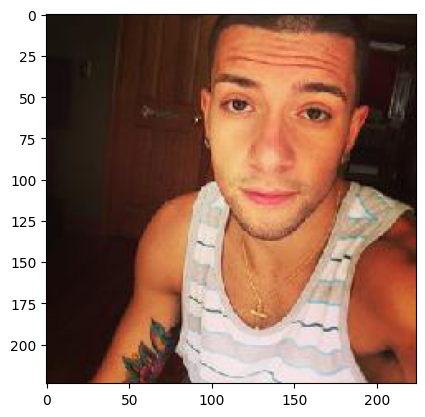


The label of this image is: non-cyberbullying


In [17]:
#@markdown Select a number to view the image and its label.

picture_index  = "11" #@param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
index = int(picture_index)
instance = test_set[index]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(test_set.samples[index][0])
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if test_set[index]['label']==1 else "non-cyberbullying"
print('')
print("The label of this image is: {}".format(annot_label))

Run the following code cell to check the AI's prediction

In [18]:
# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparision))

The AI prediction for this image is: cyberbullying, which is not correct!


## Model Fine-Tuning



- - - -
**<font color='red'>Task 3:</font>
Write code to fine-tune the model with the training dataset**

**The training dataset will be prepared via the following code cells.**

- - - -

In [19]:
# download the training data
!wget -O cyberbullying_train_data.zip https://buffalo.box.com/shared/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip

--2023-05-04 13:50:39--  https://buffalo.box.com/shared/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.144
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from buffalo.box.com attempted to set domain to box.net
Location: /public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip [following]
--2023-05-04 13:50:39--  https://buffalo.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from buffalo.box.com attempted to set domain to box.net
Location: https://buffalo.app.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip [following]
--2023-05-04 13:50:40--  https://buffalo.app.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112

In [20]:
# unzip the training data
%%capture
!unzip "/content/cyberbullying_train_data.zip" -d "/content"

In [21]:
# prepare the training data
train_set = PosesDataset('cyberbullying_train_data/cyberbullying_data_splits_clean/train/', 'cyberbullying_train_data/cyberbullying_poses/train/', 'cyberbullying_train_data/cyberbullying_data_auxes/train/')
# remove .DS_Store files if they exist
train_set.samples = [x for x in train_set.samples if '.DS_Store' not in x[0]]
# prepare the dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 12, shuffle = True)

In [22]:
# copy the pre-trained model for fine-tuning
ft_model = torch.load("auxes_17.pt")
ft_model.to(device)

CB(
  (conv1): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  (f): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPo

In [23]:
# prepare the optimizer, loss function, learning rate
optimizer = optim.Adam(ft_model.parameters(), lr = 1e-4)

In [24]:
# TODO: complete the following code by replace "___", to mimic fine-tune (further training) the model
ft_model.train()

epochs = 3
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        inputs = data['image'].to(device)
        aux = data['aux'].to(device) 
        labels = data['label'].to(device)
        optimizer.zero_grad() # zero the parameter gradients
        outputs = ft_model(inputs, aux) # forward pass
        loss = criterion(outputs, labels) # compute loss via comparing model's outputs and our predefined labels
        loss.backward() # backward pass
        optimizer.step() # update weights
        running_loss.append(loss.item()) # save loss
        _, predicted = torch.max(outputs.data, 1) # get predictions
        total += labels.size(0) # update total
        correct += (predicted == labels).sum().item() # update correct predictions
        if i % 50 == 0: # print every 50 mini-batches
            print('Epoch: %d, Iteration: %d, Loss: %.4f, Accuracy: %.4f' % (epoch, i, loss.item(), correct / total))
            correct, incorrect, total = 0.0, 0.0, 0.0 # reset correct, incorrect, and total. hint: float is better than int

# Note: 
# This code is a very basic version that helps us keep training the model with the training set, 
# Recall from the last lecture, we can have a validation set to help us decide when to stop training 
# the model. 
# If you are interested, you can try to split the training set into training set and validation set, 
# and use the validation set to help you decide when to stop training the model

Epoch: 0, Iteration: 0, Loss: 0.3146, Accuracy: 0.9062
Epoch: 0, Iteration: 50, Loss: 0.3966, Accuracy: 0.8917
Epoch: 0, Iteration: 100, Loss: 0.4799, Accuracy: 0.8567
Epoch: 0, Iteration: 150, Loss: 0.3966, Accuracy: 0.8767
Epoch: 0, Iteration: 200, Loss: 0.4799, Accuracy: 0.8533
Epoch: 1, Iteration: 0, Loss: 0.6466, Accuracy: 0.7222
Epoch: 1, Iteration: 50, Loss: 0.3966, Accuracy: 0.8600
Epoch: 1, Iteration: 100, Loss: 0.3133, Accuracy: 0.8633
Epoch: 1, Iteration: 150, Loss: 0.4799, Accuracy: 0.8850
Epoch: 1, Iteration: 200, Loss: 0.4799, Accuracy: 0.8750
Epoch: 2, Iteration: 0, Loss: 0.7299, Accuracy: 0.7222
Epoch: 2, Iteration: 50, Loss: 0.4799, Accuracy: 0.8883
Epoch: 2, Iteration: 100, Loss: 0.4799, Accuracy: 0.8800
Epoch: 2, Iteration: 150, Loss: 0.5633, Accuracy: 0.8667
Epoch: 2, Iteration: 200, Loss: 0.3966, Accuracy: 0.8517



- - - -
**<font color='red'>Task 4:</font>
Write code to print out your fine-tuned model's results, you can refer the code how we generate results for test dataset previously.**
 
**Compare the the two results you get, is the prediction accuracy better than the previous model? 
If not, think about the reasons for it perhaps.**
- - - -

In [25]:
ft_model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
        y_test_ = model(x_test, aux_test) # forward pass for the fine-tuned model
        _, predicted = torch.max(y_test_.data, 1)
        if y_test == 1 and predicted == 1:
            tp += 1
        elif y_test == 1 and predicted == 0:
            fn += 1
        elif y_test == 0 and predicted == 1:
            fp += 1
        elif y_test == 0 and predicted == 0:
            tn += 1

# TODO: write code to evaluate the model on the test set
acc = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print('The accuracy for test dataset is: {}%'.format(acc * 100))
print('The precision for test dataset is: {}%'.format(precision * 100))
print('The recall for test dataset is: {}%'.format(recall * 100))
print('The f1 score for test dataset is: {}%'.format(f1 * 100))

The accuracy for test dataset is: 85.0%
The precision for test dataset is: 88.88888888888889%
The recall for test dataset is: 80.0%
The f1 score for test dataset is: 84.21052631578948%



- - - -
**<font color='red'>Task 5:</font>
Write code to visualize the image "/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/fingerGunAnnotated_239.JPEG".<br>
Then test this image with the fine-tuned model and print the prediction results.**
- - - -

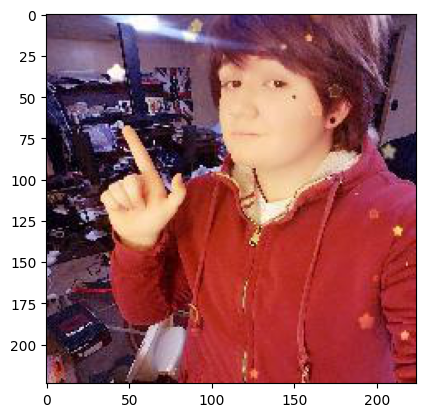


The label of this image is: non-cyberbullying


In [26]:
from PIL import Image
image = "/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/fingerGunAnnotated_239.JPEG"
img = Image.open(image)
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if test_set[index]['label']==1 else "non-cyberbullying"
print('')
print("The label of this image is: {}".format(annot_label))

# TODO: write code to plot the image and its label
# hint: use plt.imshow()


In [27]:
# TODO: find the picture_index of the chosen image by comparing with the previous visualization cell
picture_index = 0
instance = test_set[picture_index]

# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

# TODO: get the prediction for the image
output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparison = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparison))

The AI prediction for this image is: cyberbullying, which is correct!
